# Project 1: Image recognition 
**EQ2415 Machine learning for data science**

Perform all (or as many as you can) of the tasks in this project assignment. You are going to present your work to the course responsible or one of the teaching assistants (TA) and it pays off to have a clear, well structured and brief notebook. Include an algorithmic solution and/or numerical result and/or a graph illustrating your results. Your code should be functioning and easy to read.

**Objective**
The goal of this project is to implement the inference methods introduced in Tutorials 1 to 5, for an image recognition problems.

**Dataset**
We will use a standard image recognition dataset, the MNIST dataset, originally used in this [paper](https://arxiv.org/pdf/1102.0183.pdf).
Today the dataset is widely used and can save some data preparation time by downloading it directly from the scikit-learn library. 

**Tasks**
The coding and discussion tasks are indicated through out the notebook.

In [1]:
from sklearn.datasets import load_digits,make_moons
import matplotlib.pyplot as plt
import numpy as np
import cvxopt
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing

mnist = load_digits()

/Users/ruihanzhang/opt/anaconda3/envs/project1/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Let us start by visualising our dataset. This dataset contains images of handwritten 0-9 digits, and their corresponding class.

### Task
- Use the `plt.imshow` function to plot an example image from the dataset
- Print the class of the sample you display

The dataset has 1797 pictures, each containing 64 pixels.


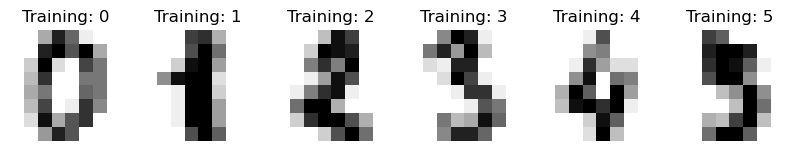

In [293]:
print('The dataset has %d pictures, each containing %d pixels.' % mnist.data.shape)
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 3))
for ax, image, label in zip(axes, mnist.images, mnist.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("Training: %i" % label)


## Part 1 - Linear models

Suppose that we can observe two variables: $\mathbf{x}\in\mathbb{R}^d$ and $\mathbf{y}\in\mathbb{R}^q$. 
Suppose also that these variables are related, and that we model this relation with a linear model parameterized with a matrix $A\in\mathbb{R}^{q\times d}$, i.e. such that \begin{equation}
    \mathbf{y}=A\mathbf{x}.
\end{equation}

In this part of the project, we will implement the MMSE solutions we derived for $A$ in tutorial 1.
Before that, we need to do some small transformations to our dataset input.
### Preparing the input data
You should have noted that the dataset consists in $N=1797$ images, represented as matrices of size $8 \times 8$. This is incompatible with our model which assumes that the data are vectors !

In the context of image recognition, $\mathbf{x}\in\mathbb{R}^d$ is the vectorized (i.e. the original matrix of size $8 \times 8$ is transformed into a vector of size $d=w\times h$) representation of an input image.

In [294]:
print("Input tensor shape:",mnist.images.shape)

Input tensor shape: (1797, 8, 8)


### Task
- Transform the input tensor into a matrix $X$ of size $64 \times 1797$.

In [295]:
X = mnist.data.T
print("Input tensor shape:", X.shape)

Input tensor shape: (64, 1797)


### Preparing the target data

Here the target data is a sequence of $N$ digits, from $0$ to $9$.
For simplicity here, we will consider the default task of classifying each input image to it's corresponding 0-9 digit. This means that we need target vectors of dimension $q=10$.

In [296]:
print("Target shape:",mnist.target.shape, "e.g.",mnist.target[:11], "...")

Target shape: (1797,) e.g. [0 1 2 3 4 5 6 7 8 9 0] ...


The targets provided in the dataset are integer numbers (i.e. vectors of dimension $1$ !). We could consider a classification task with 1-dimension targets, however for classification tasks with $10$ classes, it is easier to encode the integer targets as 10-dimensional **one-hot vectors**.

A one-hot vector is a way to encode integer number as a vector. It is a vector where all the components have value $0$, except for one, corresponding to the encoded integer, with value $1$.
For instance, in our context with $10$ possible classes:
- integer $1$ will be represented as the 10-dimensional vector: $[0,1,0,0,0,0,0,0,0,0]^T$, 
- integer $9$ will be represented as the 10-dimensional vector: $[0,0,0,0,0,0,0,0,0,1]^T$, 

### Task
- Transform the target tensor into a matrix $Y$ of size $10 \times 1797$, containing the one-hot encoded vectors columnwise.

**Hint** The scikit-learn library contains tools to perform such transformations in module `sklearn.preprocessing`. You can also get it done using the `numpy` library only.

In [297]:
Y = np.zeros((10, mnist.target.size))
Y[mnist.target, range(mnist.target.size)] = 1
print("Target tensor shape:", Y.shape)

Target tensor shape: (10, 1797)


You should now have data represented as Question 2 in section 1.3 of tutorial 1.
This means that we are ready to implement the methods!

## Implementing the algorithms

In what follows, we suppose that we have $n=1797$ data points for $\mathbf{x}$ and $\mathbf{y}$, in the form of matrices $X\in\mathbb{R}^{d\times n}$ and $Y\in\mathbb{R}^{q\times n}$ respectively, with $q=10$ and $d=64$.

###  Regularized mean squared error solution

### Task
- Implement the method derived in section 1.3, question 3 of tutorial 1.
i.e. implement the method to calculate $A_n^\star$ which leads to the minimum mean squared error for the regularized linear model. 

**Hint** Use a regularization parameter $\lambda=1$ for debugging.


### Task
- Write a function to calculate the mean squared error.
- What is the mean squared error on the dataset for $\lambda=1$ ?

In [298]:
def mse(Y, Yhat):
    return ((Y - Yhat)**2).mean()

def get_mmse(X,Y,Lambda=1): # minimum mean square error

    #return Y @ X.T @ np.linalg.inv( X @ X.T ) # without regulizer   (but returns singular matrix, not computable, idk how to fix)
    return Y @ X.T @ np.linalg.inv( X @ X.T + Lambda * np.identity(X.shape[0]) )

In [299]:
Astar = get_mmse(X,Y)
Yhat = Astar @ X

print(mse(Y,Yhat))

0.031003030804744737


### Task
- What is the classification accuracy on the dataset for $\lambda=1$ ?

**Hint 1** To obtain an accuracy you should 
1. Transform the predictions you obtain with a softmax function (see below)
2. Classify each input vector by determining which row of the predicted vector has maximum value.

**Hint 2** The module `sklearn.metrics` contains a function to calculate the accuracy. You can also compute it using only `numpy`

In [300]:
def softmax(Y):
    """Matrix of size (q x n), with prediction vectors columnwise."""
    Y_softmax = np.zeros(Y.shape)
    for i in range(Y.shape[1]):
        Y_softmax[:,i] = np.exp(Y[:,i]) / ( np.exp(Y[:,i]).sum() )
    return Y_softmax

In [301]:
y_true = mnist.target
y_pred = np.argmax(softmax(Yhat),axis=0)
accuracy = metrics.accuracy_score(y_true, y_pred)
print('The accuracy is :' , accuracy)

The accuracy is : 0.9471341124095715


### Task
1. Plot the MSE against the regularization parameter $\lambda$. Vary $\lambda$ in an interval you find relevant.
2. What do you expect to see when the value of $\lambda$ becomes large ? Does this match with the observation you can make from your graph ?
3. Propose an explaination for what you see on the graph.
4. Repeat tasks 1-3 with the accuracy instead of the MSE (you can use the same interval for $\lambda$).

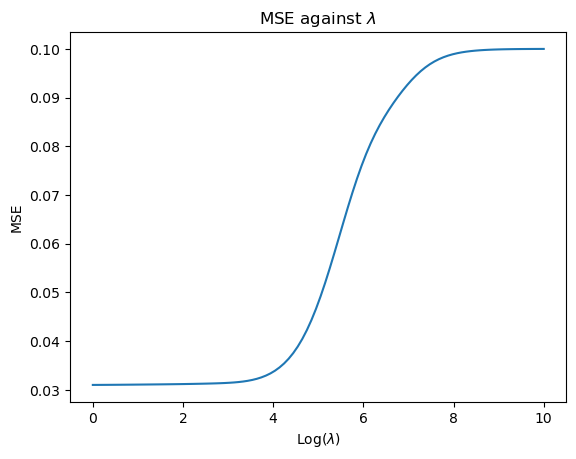

In [302]:
MSE = []
for Lambda in np.logspace(0, 10, num=100):
    Astar = get_mmse(X,Y, Lambda=Lambda)
    Yhat = Astar @ X
    MSE.append(mse(Y,Yhat))

plt.plot(np.log10(np.logspace(0, 10, num=100)), MSE)
plt.xlabel('Log($\lambda$)')
plt.ylabel('MSE')
plt.title('MSE against $\lambda$')

plt.show()


### *Answers:*

As $\lambda$ shrinks to 0, the model becomes overfitting with the data. So, on the other hand, as $\lambda$ becomes large, the model gets underfit. Thus, resulting in the rise of the curve.

There's an upper limit and a lower limit for the curve. This is due to you cannot go beyond exactly fitting the observed data. And when you have the regulizer going to big, all the weights go near zero.

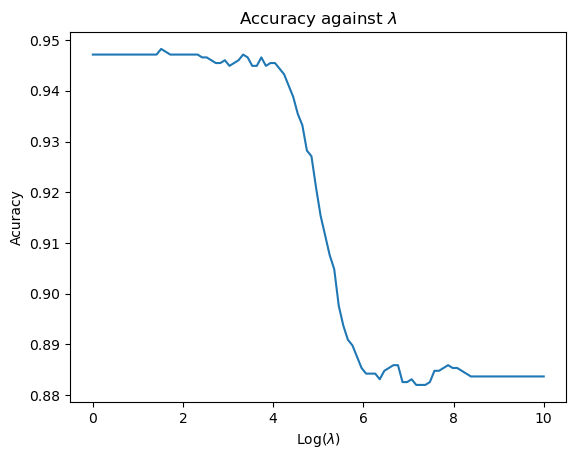

In [303]:
ACC = []
for Lambda in np.logspace(0, 10, num=100):
    Astar = get_mmse(X,Y, Lambda=Lambda)
    Yhat = Astar @ X
    y_true = mnist.target
    y_pred = np.argmax(softmax(Yhat),axis=0)
    ACC.append( metrics.accuracy_score(y_true, y_pred) )

plt.plot(np.log10(np.logspace(0, 10, num=100)), ACC)
plt.xlabel('Log($\lambda$)')
plt.ylabel('Acuracy')
plt.title('Accuracy against $\lambda$')

plt.show()

### *Answers:*

When $\lambda$ is close to a small number, the model becomes overfitting. So the accuracy is very high(close to 1) because we are evaluating on the data we used for training. On the other hand, as $\lambda$ becomes large, the model gets underfit, so the accuracy degrades.

### Task

- Plot the confusion matrix for the classification results obtained for some value of $\lambda$.
- What additional information can you obtain from the confusion matrix regarding the performances of our prediction ?

**Hint** You can find some information and functions to calculate and use confusion matrices in the `sklearn.metrics` module.

log(lambda) =  5.0
The accuracy is  0.9187534780189204


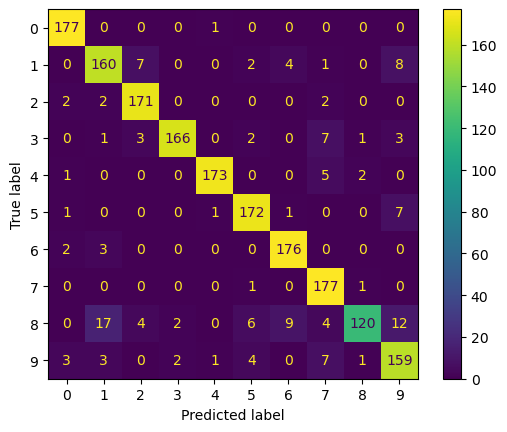

In [304]:
Lambda = 100000
print('log(lambda) = ' , np.log10(Lambda))
Astar = get_mmse(X,Y, Lambda=Lambda)
Yhat = Astar @ X
y_true = mnist.target
y_pred = np.argmax(softmax(Yhat),axis=0)
print('The accuracy is ', metrics.accuracy_score(y_true, y_pred))
cm = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

### *Answer:*
The confusion matrix shows that 1 and 8 are the most mispredicted hand-writen digits for $\lambda = 100000$. And similarly, 5 and 8, 6 and 8, with lower errors. So, the digit 8 is the hardest one for our model to recognize.

## Part 2 - Kernel regression

A kernel based predictor differs from a linear predictor in that it performs linear prediction on a transformed version of the input rather than of the input directly.
The transformation is performed by a function (let's call it $\boldsymbol\phi$) mapping input vectors to vectors in a space of arbitrary dimension $N>d$, i.e. $\boldsymbol\phi:\mathbb{R}^d\rightarrow\mathbb{R}^N$.
The prediction for a vector $\mathbf{x}\in\mathbb{R}^d$ is written as
$\begin{equation}
    \hat{\mathbf{y}}=\mathbf{w}^T\boldsymbol\phi(\mathbf{x}), 
\end{equation}$
where $\mathbf{w}$ are parameters of the predictor.
In other words, kernel predictors are linear predictors in higher dimensional spaces.

For this part of the project, refer to the theory presented in tutorial 1 section 1.4.
The implementation tasks below are the ones proposed in the in question 4, 5 and 6.

### Task

- Implement a function in Python that calculates the Gram matrix associated with a linear kernel.
Your function should take as argument two sets of vectors in $\mathbb{R}^d$ in the form of two matrices, e.g. $X_1\in\mathbb{R}^{d\times n}$ and $X_2\in\mathbb{R}^{d\times m}$, and return the Gram matrix $K\in\mathbb{R}^{n\times m}$.


In [13]:
def my_linear_kernel(X1, X2):
    """ Applies a linear kernel to two inputs datasets
    Given
        X1: (d,n) ndarray
        X2: (d,m) ndarray
    Returns
        (n,m) ndarray
    """
    return X1.T @ X2

### Task

- Similarly, implement a function in Python that calculates the Gram matrix associated with a RBF kernel.

In [11]:
def my_rbf_kernel(X1, X2, gamma=1e-3):
    """ Applies a RBF kernel of parameter gamma to two inputs datasets
        Given
            X1: (d,n) ndarray
            X2: (d,m) ndarray
        Returns
            (n,m) ndarray
    """
    n = X1.shape[1]
    m = X2.shape[1]
    K = np.zeros([n,m])
    ## Using for-loops is slow in compution, 
    for i in range(n):
        for j in range(m):
            K[i,j] = np.exp( - gamma * np.linalg.norm(X1[:,i] - X2[:,j])**2 )
    return K

In [14]:
def my_rbf_kernel_2(X1, X2, gamma=1e-3): ## Vectorized version. Computes faster.
    """ Applies a RBF kernel of parameter gamma to two inputs datasets
        Given
            X1: (d,n) ndarray
            X2: (d,m) ndarray
        Returns
            (n,m) ndarray
    """
    n = X1.shape[1]
    m = X2.shape[1]
    K = np.zeros([n,m])
    K += np.sum(X1**2, axis=0).reshape(n,1)
    K += np.sum(X2**2, axis=0).reshape(1,m)
    K -= 2 * (X1.T @ X2)
    K = np.exp( - gamma * K )

    return K

### Task
- Implement and test the kernel regression predictor on the classification dataset and compare the performances with the linear method implemented in part 1.

In [308]:
def get_prediction(X,Y,Xhat,Lambda=1,kernel='linear'):
    ## Get the predicion result using kernel regression
    if kernel == 'rbf':
        Yhat = Y @ np.linalg.inv(my_rbf_kernel_2(X,X) + Lambda * np.identity(X.shape[1])) @ my_rbf_kernel_2(X,Xhat)
    else:
        Yhat = Y @ np.linalg.inv(my_linear_kernel(X,X) + Lambda * np.identity(X.shape[1])) @ my_linear_kernel(X,Xhat)
    y_pred = np.argmax(softmax(Yhat),axis=0)
    return y_pred

In [309]:
X_train = X[:,:1000]
Y_train = Y[:,:1000]
X_test = X[:,1000:]
y_true = mnist.target[1000:]
print('With Lambda set to default value 1:')
print('The accuracy using the linear kernel is ', metrics.accuracy_score(y_true, get_prediction(X_train,Y_train, X_test)))
print('The accuracy using the RBF kerbel is ', metrics.accuracy_score(y_true, get_prediction(X_train,Y_train, X_test, kernel='rbf')))

With Lambda set to default value 1:
The accuracy using the linear kernel is  0.8920953575909661
The accuracy using the RBF kerbel is  0.9661229611041405


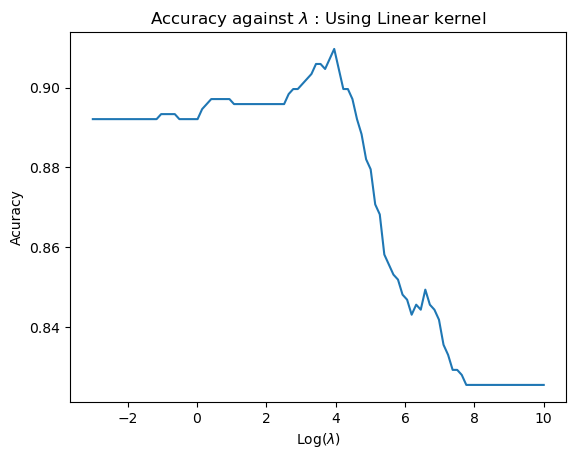

In [310]:
L_range = np.logspace(-3, 10, num=100)
ACC = []
for Lambda in L_range:
    ACC.append(metrics.accuracy_score(y_true, get_prediction(X_train, Y_train, X_test, Lambda)))

plt.plot(np.log10(L_range), ACC)
plt.xlabel('Log($\lambda$)') 
plt.ylabel('Acuracy')
plt.title('Accuracy against $\lambda$ : Using Linear kernel')
plt.show()

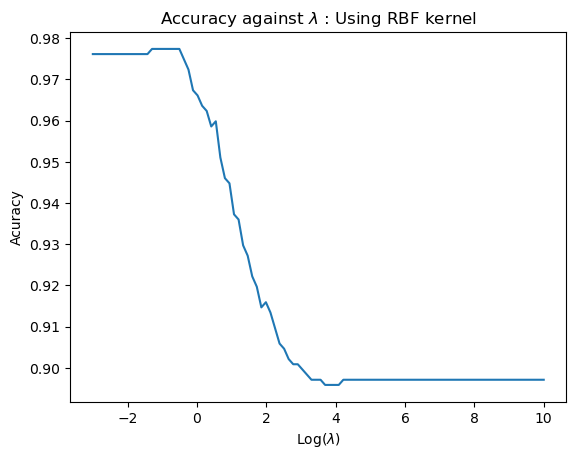

In [311]:
L_range = np.logspace(-3, 10, num=100)
ACC = []
for Lambda in L_range:
    ACC.append(metrics.accuracy_score(y_true, get_prediction(X_train, Y_train, X_test, Lambda, kernel='rbf')))

plt.plot(np.log10(L_range), ACC)
plt.xlabel('Log($\lambda$)') 
plt.ylabel('Acuracy')
plt.title('Accuracy against $\lambda$ : Using RBF kernel')
plt.show()

From the two graphs above we could see that: The performance of the RBF kernel is overall better than the linear kernel. And if we use a good Lambda to regulate both alogirthm, the RBF kernel will perform signicantly better than the linear kernel.

## Part 3 - Kernel substitution (SVM)

In this part of the project, you are going to implement the optimization problem of the Support Vector Machine (SVM) and compare its performances with the algorithms of the previous part.
For simplicity and to keep the focus on the optimization problem, we will implement SVM for a binary classification task.

### Dataset

The dataset we used for linear prediction is a multiclass classification dataset, we thus need to adapt the dataset to perform a binary classification task.

#### Task
- Come up with a binary classification task on the image dataset we introduced above. Present in details the input and target data you will be using.
- Compute the baseline performance on this new task with the linear prediction algorithm in part 1.

The dataset has 360 pictures, each containing 64 pixels.


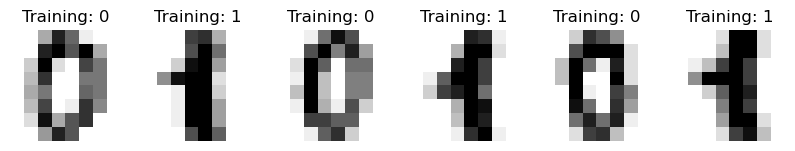

In [2]:
# Load the two class digit dataset.
mnist_2 = load_digits(n_class=2)
print('The dataset has %d pictures, each containing %d pixels.' % mnist_2.data.shape)
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 3))
for ax, image, label in zip(axes, mnist_2.images, mnist_2.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("Training: %i" % label)

In [3]:
## Preparing the data
X = mnist_2.data.T
print("Input tensor shape:", X.shape)

Y = np.zeros((2, mnist_2.target.size))
Y[mnist_2.target, np.arange(mnist_2.target.size)] = 1
print("Target tensor shape:", Y.shape)

Input tensor shape: (64, 360)
Target tensor shape: (2, 360)


In [4]:
## Split the data into training set and test set.
X_train = X[:,:180]
Y_train = Y[:,:180]
X_test = X[:,180:]
Y_test = Y[:,180:]
y_true = mnist_2.target[180:]
print("Training set input tensor shape:", X_train.shape)
print("Test set input tensor shape:", X_test.shape)

Training set input tensor shape: (64, 180)
Test set input tensor shape: (64, 180)


In [5]:
def mse(Y, Yhat):
    return ((Y - Yhat)**2).mean()

def get_mmse(X,Y,Lambda=1): # minimum mean square error

    #return Y @ X.T @ np.linalg.inv( X @ X.T ) # without regulizer   (but returns singular matrix, not computable, idk how to fix)
    return Y @ X.T @ np.linalg.inv( X @ X.T + Lambda * np.identity(X.shape[0]) )

In [6]:
Astar = get_mmse(X_train,Y_train)
Yhat = Astar @ X_test
y_pred = np.argmax(Yhat,axis=0)
accuracy = metrics.accuracy_score(y_true, y_pred)
print('MSE is', mse(Y_test,Yhat))
print('The accuracy for the linear regresison algorithm is :' , accuracy)

MSE is 0.029854449995109677
The accuracy for the linear regresison algorithm is : 0.9777777777777777


### The SVM optimization problem

Recall that the optimization problem of a Support Vector Machine can be written as a quadratic program (QP):
\begin{equation}
    \underset{\mathbf{w}}{\text{minimize }} \frac{1}{2} ||\mathbf{w}||_2 \\
    \text{subject to } (\mathbf{w}^T\phi(\mathbf{x}_i) + \mathbf{b})\mathbf{y}_i \geq 0, \text{ for } i=1,\cdots,n.
\end{equation}

This initial problem is to be reformulated before it can be implemented.
This is because this problem depends upon function $\phi$, which as we saw, leads to a vector of infinite dimension for the RBF kernel and cannot be implemented.
The problem is to be reformulated into another QP where we can use the Gram matrix associated with the RBF kernel on the training data instead of $\phi$.

### Task
- Make sure that you understood the derivation of the problem in tutorial 3 !

### Implementation

In Python you can find a lot of libraries to help you solve QPs with efficient algorithms.
One such library is `cvxopt`. 
In this library you will find an algorithm for solving quadratic problems formulated in a standard way.

The solver is implemented in function `cvxopt.solvers.qp` and solves problems formulated as:

\begin{align}
\underset{\mathbf{w}}{\text{minimize }}\quad&    \frac{1}{2}\mathbf{w}^T P\mathbf{w} + \mathbf{q}^T\mathbf{w}\\
\text{subject to } \quad&   G\mathbf{w} <= \mathbf{h}\\
            & A\mathbf{w} = \mathbf{b}.
\end{align}

**Input arguments**

- P is a n x n dense or sparse 'd' matrix with the lower triangular part of P stored in the lower triangle.  Must be positive semidefinite.

- q is an n x 1 dense 'd' matrix.

- G is an m x n dense or sparse 'd' matrix.

- h is an m x 1 dense 'd' matrix.

- A is a p x n dense or sparse 'd' matrix.

- b is a p x 1 dense 'd' matrix or None.

- solver is None or 'mosek'.

The default values for G, h, A and b are empty matrices with zero rows.

You will find the complete doc here : http://cvxopt.org/index.html

### Task 
- Implement the support vector machine optimization algorithm using the `cvxopt` library. Your algorithm should work with the linear and RBF kernels.

In [7]:
X_train = X[:,:180]
X_test = X[:,180:]
y_true = mnist_2.target[180:]
t = mnist_2.target[:180]
t[t == 0] = -1

In [26]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

def get_svm(X_train, X_test, t, gamma=1e-3, kernel='linear'):
    d = X_train.shape[1]
    if kernel == 'linear':
        P = my_linear_kernel(X_train,X_train)
    else:
        P = my_rbf_kernel_2(X_train,X_train,gamma)
    P *= t.reshape(d,1)
    P *= t.T.reshape(1,d)
    P = matrix(P)

    q = matrix(-np.ones((d,1)))
    h = matrix(-np.zeros((d,1)))
    G = matrix(-np.identity(d))
    A = matrix(t, (1, d), 'd')
    B = matrix([0],(1,1),'d')

    sol=solvers.qp(P, q, G, h, A, B)
    a = np.array(sol['x'])

    if kernel == 'linear':
        b = t - (a * t.reshape(d,1)).T @ my_linear_kernel(X_train, X_train)
    else:
        b = t - (a * t.reshape(d,1)).T @ my_rbf_kernel_2(X_train, X_train,gamma)
    b = np.average(b)

    if kernel == 'linear':
        y = (a * t.reshape(d,1)).T @ my_linear_kernel(X_train, X_test) + b
    else:
        y = (a * t.reshape(d,1)).T @ my_rbf_kernel_2(X_train, X_test,gamma) + b
    y = y.ravel()
    y[y > 0] = 1
    y[y < 0] = 0

    return y

### Model evaluation

Now that the SVM is implemented, we can test it and compare its performances with other methods.


### Tasks
- Compare the performances of the linear and RBF kernel based SVM on the binary classification task.
- Study the influence of the RBF's kernel scaling parameter.
- What is the difference between a linear SVM and the linear classification algorithm (with $\lambda=0$) of part 1 ?
- Compare the performances of the linear algorithms with the RBF kernel based SVM.
- Discuss your findings

In [27]:
y_pred = get_svm(X_train, X_test, t, kernel='linear')
accuracy = metrics.accuracy_score(y_true, y_pred)
print('The accuracy for the svm with linear kernel:' , accuracy)

The accuracy for the svm with linear kernel: 0.9944444444444445


In [321]:
y_pred = get_svm(X_train, X_test, t, kernel='rbf')
accuracy = metrics.accuracy_score(y_true, y_pred)
print('The accuracy for the svm with RBF kernel:' , accuracy)

The accuracy for the svm with RBF kernel: 1.0


The RBF kernel works slightly better.

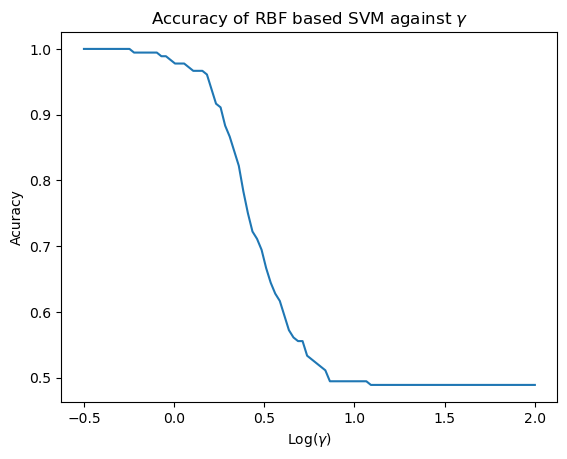

In [322]:
G_range = np.logspace(-0.5, 2, num=100)
ACC = []
for Gamma in G_range:
    y_pred = get_svm(X_train, X_test, t, Gamma, kernel='rbf',)
    ACC.append( metrics.accuracy_score(y_true, y_pred) )

plt.plot(np.log10(G_range), ACC)
plt.xlabel('Log($\gamma$)')
plt.ylabel('Acuracy')
plt.title('Accuracy of RBF based SVM against $\gamma$')
plt.show()

- What is the difference between a linear SVM and the linear classification algorithm (with $\lambda=0$) of part 1 ?

*Answer:* 

They both have straight decision boundries in the hyperplane. But the linear classification algorithm doesn't have an intercept, the plane goes through the origin and ignores the distance between the class and the origin (i.e. something relates to the overall shape of the the class).
The linear SVM will have an intercept, and draws a decision boundry which is not constrained to the origin, hence more reasonable.

And the linear classifier will look at all the distances of the datapoints to the decision boundry, which is heavy and could be easily damged by some irregular data. But the SVM only cares about few of the closest data points in-between the two classes. It won't be bothered by the other datapoints, and won't have to store a very large weight matrix (a sparse matrix instead).

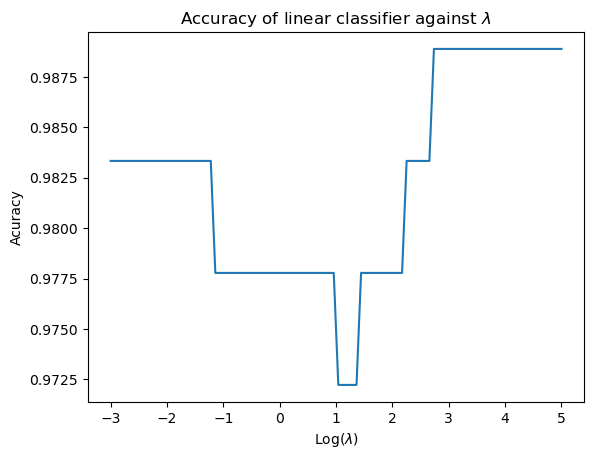

In [323]:
ACC = []
for Lambda in np.logspace(-3, 5, num=100):
    Astar = get_mmse(X_train,Y_train, Lambda)
    Yhat = Astar @ X_test
    y_pred = np.argmax(Yhat,axis=0)
    ACC.append( metrics.accuracy_score(y_true, y_pred) )

plt.plot(np.log10(np.logspace(-3, 5, num=100)), ACC)
plt.xlabel('Log($\lambda$)')
plt.ylabel('Acuracy')
plt.title('Accuracy of linear classifier against $\lambda$')
plt.show()


- Compare the performances of the linear algorithms with the RBF kernel based SVM.

- Discuss your findings

*Answer:* 

The RBF SVM give a better result when we have chosen the correct $\gamma$. But if gamma is not so good, we would end up with horrible results. On the countrary, the linear method is very stable even if the regulizer $\lambda$ changes drammatically.

## Part 4 - Gaussian Processes

The main focus is to implement a Gaussian process model and visualize the output on a 1d regression task.


### Dataset
We propose to use a dataset generated artificially as below:

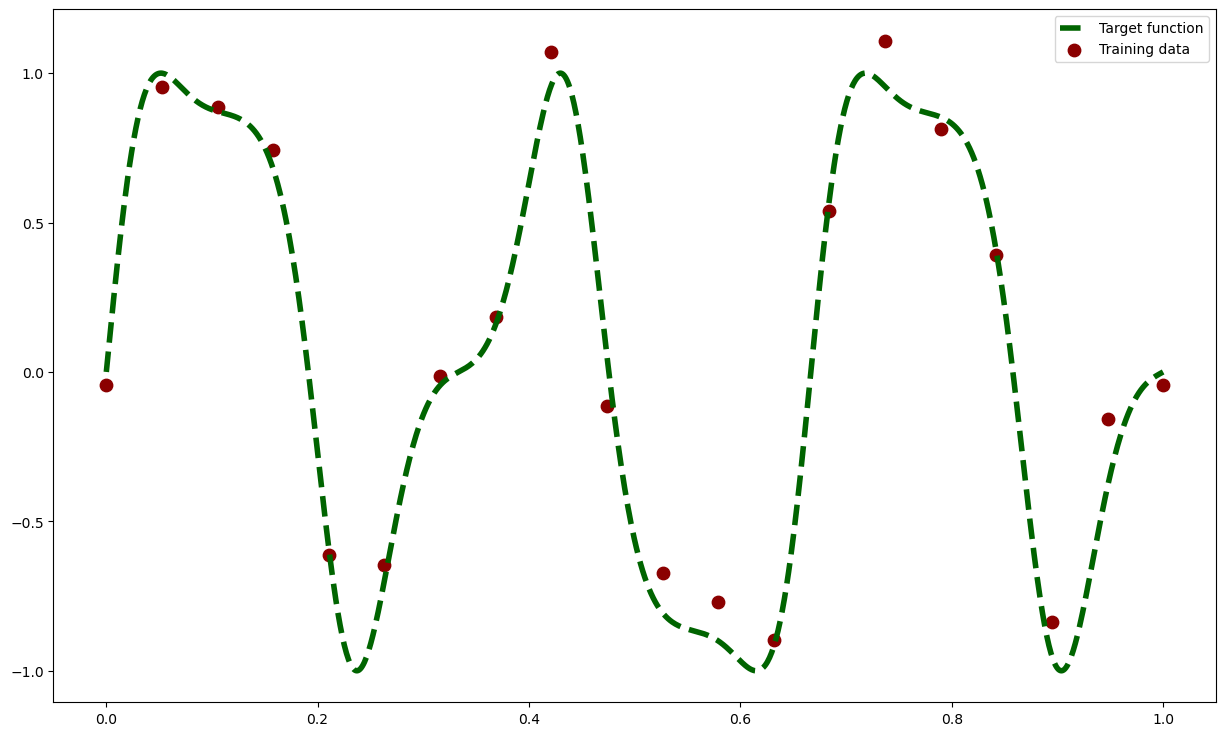

In [337]:
def sindata(n,f=3,snoise=0.1,random=True):
    if random:
        # Randomly spaced
        x = np.sort(np.random.rand(n)).reshape(-1,1)
    else:
        x = np.linspace(0,1,n).reshape(-1,1)
        
    y = np.sin(2*np.pi*x*f + 0.6*np.sin(2*np.pi*x*f*1.5 ))

    return x, y+np.random.randn(n,1)*snoise

fig, ax = plt.subplots(figsize=(15,9))

# Plot a regular line as the target function
ax.plot(*sindata(1000, snoise=0,random=False),
        linewidth=4,color="darkgreen",label="Target function",linestyle="--")

# Draw noisy data points from the trajectory above
ntrain=20
xtrain, ytrain = sindata(ntrain,snoise=.1,random=False)

ax.scatter(xtrain, ytrain, s=80,c="darkred",label="Training data")
ax.legend()

In [338]:
# Test data
xtest = np.linspace(0,1,1000).reshape(-1,1)

### Task
- Using the theory presented in tutorial 2 section 1.4, reproduce a figure similar to:

<center><img src="GPR_sinusoide_example.png"/></center>

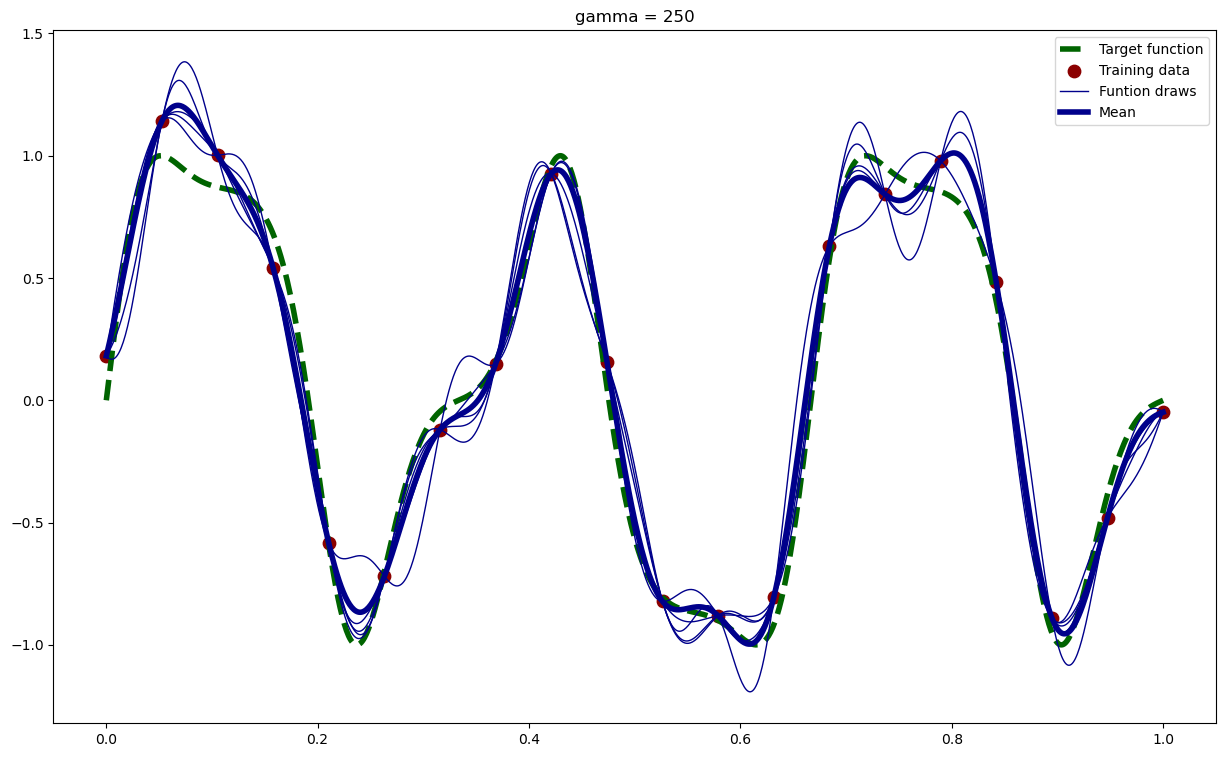

In [427]:
fig, ax = plt.subplots(figsize=(15,9))
# Plot a regular line as the target function
ax.plot(*sindata(1000, snoise=0,random=False),
        linewidth=4,color="darkgreen",label="Target function",linestyle="--")

# Draw noisy data points from the trajectory above
ax.scatter(xtrain, ytrain, s=80,c="darkred",label="Training data")

## Calculate the Gaussian process
g = 250
m = my_rbf_kernel_2(xtrain.T,xtest.T,gamma=g).T @ np.linalg.inv(my_rbf_kernel_2(xtrain.T,xtrain.T,gamma=g)) @ ytrain
cov = my_rbf_kernel_2(xtest.T,xtest.T,gamma=g) -  my_rbf_kernel_2(xtrain.T,xtest.T,gamma=g).T @ np.linalg.inv(my_rbf_kernel_2(xtrain.T,xtrain.T,gamma=g)) @ my_rbf_kernel_2(xtrain.T,xtest.T,gamma=g)

# Draw a random funtion
ytest = np.random.multivariate_normal(m.reshape(-1), cov)
ax.plot(xtest,ytest,
        linewidth=1,color="darkblue",label="Funtion draws",linestyle="-")
for i in range(4):
        ytest = np.random.multivariate_normal(m.reshape(-1), cov)
        ax.plot(xtest,ytest,
                linewidth=1,color="darkblue",linestyle="-")

# Draw the mean estimated function.
ax.plot(xtest,m,
        linewidth=4,color="darkblue",label="Mean",linestyle="-")

# ci ?
# ci = np.random.multivariate_normal(m.reshape(-1), cov, size=1000)

plt.title("gamma = 250")
ax.legend()

### Task
- How do you expect the MSE between the target function and the mean estimated function to vary with respect to:
    1. the kernel scaling parameter,
    2. the number of training data points ?
- Plot the MSE versus the scaling parameter and the MSE versus the number of training data points.
- Discuss the graphs
- How does the model behave when the test data are too far from the training data. For instance, evaluate the GP model with test data > 1.

##### *Answer:* 

1. I expect there to be optimal kernel scaling paramater which gives out the lowest MSE. So, as the kernel scaling parameter changes, the MSE curve should look like a valley shape.

2. If more data points are given for training, the more accurate our model should be. Thus, I expect to see the MSE converge to its minimum value.

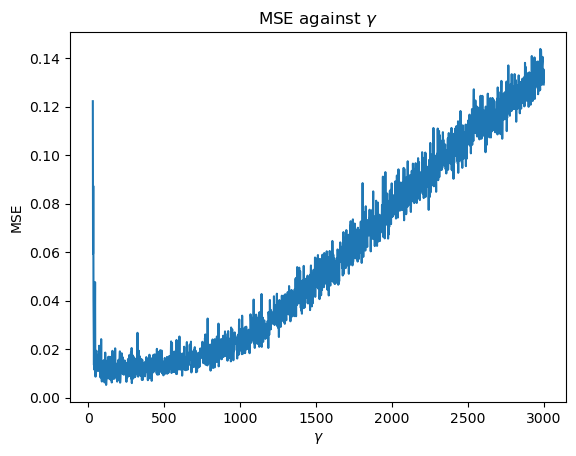

In [378]:
(x , t) = sindata(1000, snoise=0,random=False)

def get_mse(gamma, ntrain=20):
    xtrain, ytrain = sindata(ntrain,snoise=.1,random=False)
    m = my_rbf_kernel_2(xtrain.T,xtest.T,gamma).T @ np.linalg.inv(my_rbf_kernel_2(xtrain.T,xtrain.T,gamma)) @ ytrain
    return ((m - t)**2).mean()

### MSE versus the scaling parameter
gamma_range = np.linspace(30,3000,num=2000)
MSE = []
for gamma in gamma_range:
    MSE.append( get_mse(gamma) )

plt.plot(gamma_range, MSE)
plt.xlabel('$\gamma$')
plt.ylabel('MSE')
plt.title('MSE against $\gamma$')
plt.show()

When $\gamma$ gets too small(below 30), an error occurred when drawing the random Gaussian samples, which said that the input covariance is not positive-semidefinite. I guess there was some kind of calculating problems where some numbers exceed the range of a 64bit float. And as $\gamma$ increases, the MSE tend to increase too. We could see from the plot below that the 

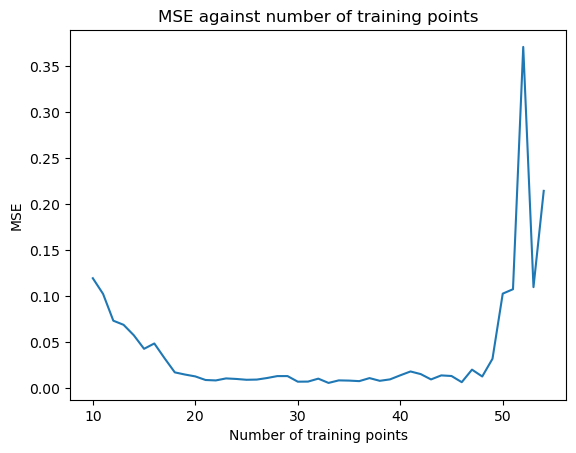

In [428]:
### MSE versus the scaling parameter
ntrain = range(10, 55, 1)
MSE = []
for n in ntrain:
    MSE.append( get_mse(250, n) )

plt.plot(ntrain, MSE)
plt.xlabel('Number of training points')
plt.ylabel('MSE')
plt.title('MSE against number of training points')
plt.show()

The curve explodes as the number of training points meets a certain threshhold.

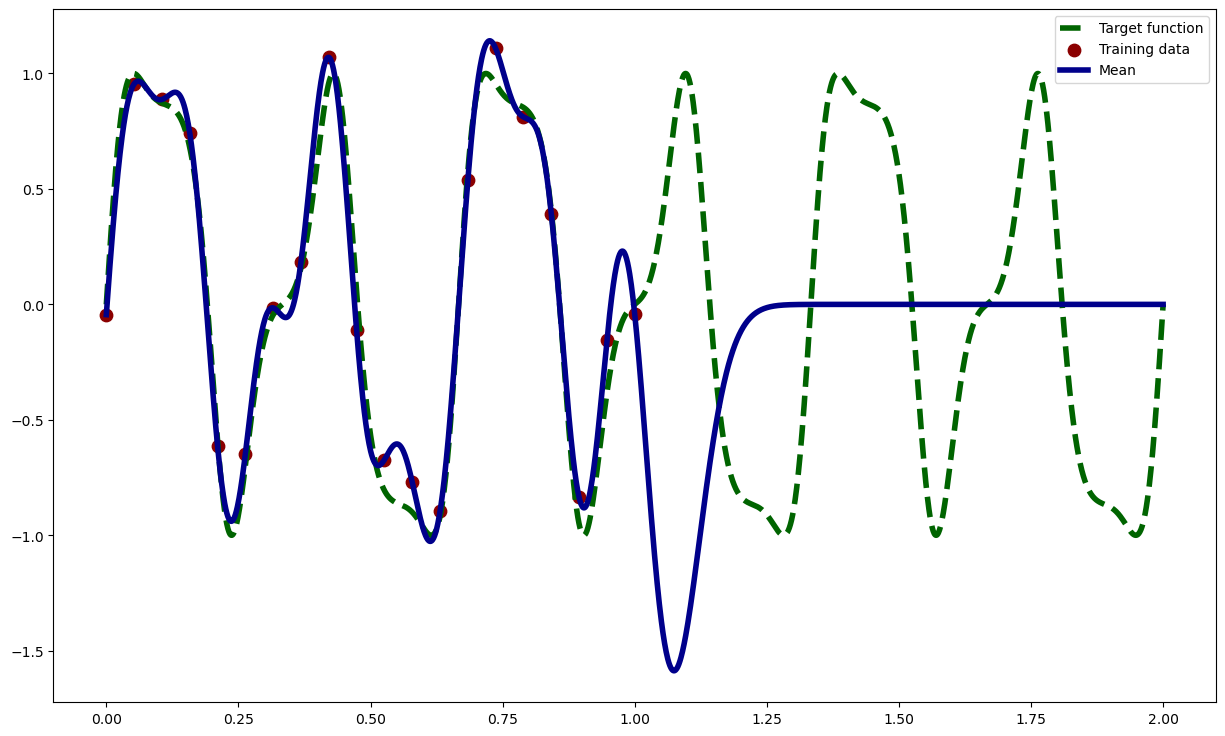

In [348]:
## How does the model behave when the test data are too far from the training data.
#  For instance, evaluate the GP model with test data > 1.
xtest2 = np.linspace(0,2,2000).reshape(-1,1)
gamma = 100

m = my_rbf_kernel_2(xtrain.T,xtest2.T,gamma).T @ np.linalg.inv(my_rbf_kernel_2(xtrain.T,xtrain.T,gamma)) @ ytrain
fig, ax = plt.subplots(figsize=(15,9))

# Plot a regular line as the target function
x = np.linspace(0,2,2000).reshape(-1,1)
y = np.sin(2*np.pi*x*3 + 0.6*np.sin(2*np.pi*x*3*1.5 ))
ax.plot(x, y,
        linewidth=4,color="darkgreen",label="Target function",linestyle="--")

# Draw noisy data points from the trajectory above
ax.scatter(xtrain, ytrain, s=80,c="darkred",label="Training data")

# Draw the mean estimated function.
ax.plot(xtest2,m,
        linewidth=4,color="darkblue",label="Mean",linestyle="-")

ax.legend()

The result is not so good when estimating data too far from the training data. The estimated mean quickly goes to zero as the uncertainty of our estimation increases with the distance away from our training data.

## Part 5 - Neural networks (Back-prop)

In this part we train a 1 hidden layer neural network on the artificial two moons dataset.
The particularity is that we manually implement the update rule of a backpropagation algorithm.
The goal is to give an insight on how machine learning toolboxes work under the hood, and to understand why we need these toolboxes to build complex training pipelines.
Here we do not use such toolboxes, but rather implement a back propagation algorithm using the numpy library.

The code was found here:
- Walkthrough backpropagation algorithm: https://cs231n.github.io/optimization-2/

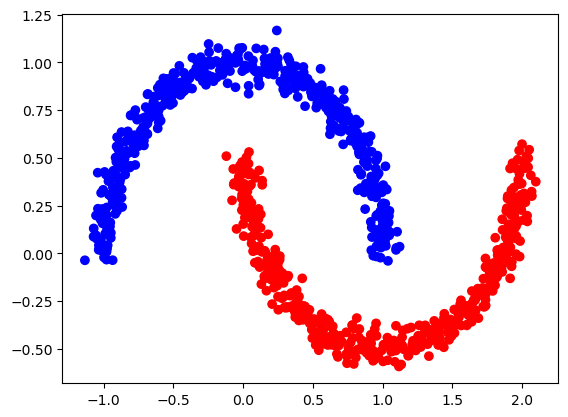

In [349]:
x,y = make_moons(n_samples=1000, noise=0.05)
y = np.hstack([1-y[:,None],y[:,None]])

colors = 'rb'
c_ = [colors[yy] for yy in y[:,0]]

fig,ax=plt.subplots()
ax.scatter(x[:,0], x[:,1], c=c_);

In [350]:
# Network definitions

d = 2 # Input space dimension
n1 = 2 # First layer hidden size
q = 2  # Target space dimension

# Activation function
def relu(x):
    return np.maximum(0,x)

# learning rate
lr=0.0001

# Initialize NN
hidden_sizes = [(d,n1), (n1,q)]
print(hidden_sizes)

[(2, 2), (2, 2)]


### Task

- Using the skeleton of code below, write the batch gradient descent algorithm for a 1-hidden layer network.

Text(0, 0.5, 'Loss')

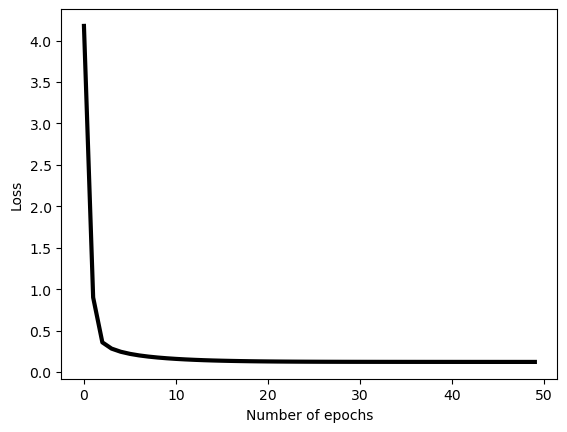

In [363]:
# Weight initialization

w1 = np.random.randn(hidden_sizes[0][1],hidden_sizes[0][0])
w2 = np.random.randn(hidden_sizes[1][1],hidden_sizes[1][0])

# Training loop
nepochs = 50

# We will save the loss at every epoch
loss = np.zeros(nepochs)

for ix in range(nepochs):
    n_samples = x.shape[0]
    # Forward pass: compute y_pred    
    #
    ## Task 1: Write the forward pass
    # Solution
    h = relu(x@w1)
    y_pred = h@w2
    # Compute loss
    loss[ix] = (0.5) * np.square(y_pred - y).mean()

    # Gradient of loss wrt network's output
    d3 = y_pred - y
    
    ## Task 2: Implement gradient descent
    grad2 = h.T @ d3
    gradh = d3 @ w2.T
    grad1 = x.T @ (gradh * (h > 0))
    
    # Update weights
    #
    ## Task 3
    w1 -= lr * grad1
    w2 -= lr * grad2

# Plot the loss
fig,ax=plt.subplots()
ax.plot(loss,'k',lw=3) 
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss")

### Task

- Evaluate the performances of the algorithm on the classification dataset.
- Compare the performances of the neural network with the algorithms implemented in the previous parts (except the GP)

In [364]:
idx = np.argmax(y_pred, axis=1)
y_temp = np.zeros((1000,2))
y_temp[range(1000),idx] = 1
accuracy = metrics.accuracy_score(y, y_temp)
print('The accuracy for the one-layer network:' , accuracy)

The accuracy for the one-layer network: 0.883


In [365]:
X = x.T
Y = y.T
y_true = np.argmax(y, axis=1)

### Linear prediction algorithm
Lambda = 100000
Astar = get_mmse(X,Y, Lambda=Lambda)
Yhat = Astar @ X
y_pred = np.argmax(softmax(Yhat),axis=0)
print('The linear algorithm accuracy is ', metrics.accuracy_score(y_true, y_pred))

### Linear kernel regression
y_pred = get_prediction(X,Y, X, kernel='linear')
print('The accuracy using the linear kernel regression is ', metrics.accuracy_score(y_true, y_pred))

### RBF kernel regression
y_pred = get_prediction(X,Y, X, kernel='rbf')
print('The accuracy using the RBF kerbel regression is ', metrics.accuracy_score(y_true, y_pred))

solvers.options['show_progress'] = False
t = y_true.copy()
t[t == 0] = -1
### SVM with Linear kernel
y_pred = get_svm(X, X, t, kernel='linear')
accuracy = metrics.accuracy_score(y_true , y_pred)
print('The accuracy for the svm with linear kernel:' , accuracy)

### SVM with RBF kernel
y_pred = get_svm(X, X, t, gamma=1, kernel='rbf')
accuracy = metrics.accuracy_score(y_true , y_pred)
print('The accuracy for the svm with RBF kernel:' , accuracy)


The linear algorithm accuracy is  0.788
The accuracy using the linear kernel regression is  0.871
The accuracy using the RBF kerbel regression is  0.827
The accuracy for the svm with linear kernel: 0.21
The accuracy for the svm with RBF kernel: 1.0


In [366]:
## A problem I encountered when implementing linear SVM:
#  "Terminated (singular KKT matrix)."

solvers.options['show_progress'] = True
y_pred = get_svm(X, X, t, kernel='linear')
accuracy = metrics.accuracy_score(y_true , y_pred)
print('The accuracy for the svm with linear kernel:' , accuracy)

     pcost       dcost       gap    pres   dres
 0: -3.3503e+02 -8.5951e+02  4e+03  4e+01  3e+00
 1: -1.1931e+03 -2.1937e+03  3e+03  3e+01  2e+00
 2: -1.4924e+03 -2.7135e+03  3e+03  3e+01  2e+00
 3: -6.0072e+03 -8.4453e+03  3e+03  2e+01  1e+00
 4: -1.3201e+04 -1.6690e+04  4e+03  2e+01  1e+00
 5: -1.5173e+04 -1.9061e+04  4e+03  2e+01  1e+00
 6: -4.4832e+04 -5.1665e+04  7e+03  2e+01  1e+00
 7: -1.9252e+05 -2.0895e+05  2e+04  2e+01  1e+00
 8: -9.4091e+05 -9.9655e+05  6e+04  2e+01  1e+00
 9: -8.9833e+06 -9.2603e+06  3e+05  2e+01  1e+00
10: -2.4895e+08 -2.5048e+08  2e+06  2e+01  1e+00
11: -3.7574e+10 -3.7592e+10  2e+07  2e+01  1e+00
12: -3.4851e+11 -3.4868e+11  2e+08  2e+01  1e+00
13: -3.4968e+11 -3.4985e+11  2e+08  2e+01  1e+00
14: -3.5046e+11 -3.5064e+11  2e+08  2e+01  1e+00
15: -3.5042e+11 -3.5060e+11  2e+08  2e+01  1e+00
16: -4.3831e+11 -4.3853e+11  2e+08  2e+01  1e+00
17: -5.4328e+11 -5.4353e+11  3e+08  2e+01  1e+00
18: -5.8261e+11 -5.8288e+11  3e+08  2e+01  1e+00
19: -6.6492e+11 -6.65

## Part 5 - Neural networks (CNN architecture)
# Supervised learning in Pytorch
Supervised learning is a type of machine learning problem a target quantity has to be infered from a set of input samples.
Classical inference tasks are regression, where a continuous target quantities has to be infered, and classification, where a discrete target is to be infered.
In this notebook we consider an image classification task.
Classically, image classification tasks are performed with careful filter engineering and feature extraction methods.
The features were then classified using classical classification algorithms, such as logistic regression or Support Vector Machine.
The classification algorithm was then tested against metrics such as mean squared error, accuracy, f1-score, ...

In 1990, the model `Lenet` was proposed.
`LeNet` directly maps input images to their label without manual filter design and is learnable end-to-end.
This enables the feature extraction pipeline and the classification algorithm to be trained jointly, without requiring engineering choices.

This model uses convolutional neural networks (CNN), a type of hidden layer which can be used to extract features on images regardless of their spatial location.
The features are extracted gradually with several repetitions of convolutional layers, non-linear activations and  pooling layers.
After the features have been extracted, the model uses fully connected layers to perform the final mapping to the image label.

The architectire is depicted below:
![Architecture](lenet.png)

Convolutional layers, pooling layers, activation functions and fully connected layers are all functions that are differentiable with respect to (wrt) their parameters.
The model is constructed so that the output can be compared to the expected output using loss functions which are differentiable wrt their input.
This allows `LeNet` to be trained using backpropagation, a gradient descent algorithm which uses the chain rule to calculate the derivative of a loss function wrt the trainable parameter.



## Objective
In this notebook, the objective is to obtain a testing performance of the `LeNet` model on the KMNIST dataset.
To achieve this, we will define our model and train it from scratch.

We will introduce the steps which must be implemented when working with a supervised learning pipeline:
- Data preparation
- Model architecture
- Training algorithm
- Testing algorithm


## Dataset

We use the KMNIST dataset which is a supervised learning classification task.
The dataset consists of 60,000 images of size 28x28 and 10 classes.


## Requirements

Basic knowledge in pytorch, follow this introduction if necessary: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

- Make sure that torch and torchvision are installed in version:
`torch==1.10.1` and `torchvision==0.11.2`


In [367]:
import numpy as np
import torch
import torchvision
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
opts= {
    "batch_size":64,
    "loss_fun": nn.CrossEntropyLoss,
    "optimizer_fun":optim.SGD,
    "optimizer_opts":{"lr":0.01, "momentum":0.9}
}
print("torch=={}".format(torch.__version__))
print("torchvision=={}".format(torchvision.__version__))
print("numpy=={}".format(np.__version__))
print("matplotlib=={}".format(mpl.__version__))

torch==1.10.2
torchvision==0.11.0a0
numpy==1.23.1
matplotlib==3.5.2


In this part the goal is to define, train and test a convolutional neural network on a classification dataset.
We introduce the key steps required to train and test any deep neural network architecture:

- Data preparation
- Model architecture
- Training algorithm
- Testing algorithm


For demonstration purpose, we use a supervised learning task on the KMNIST dataset.
The dataset can be downloaded as shown below:

Training tensor shape: 60000 28 28
Number of classes: 10
Example images:


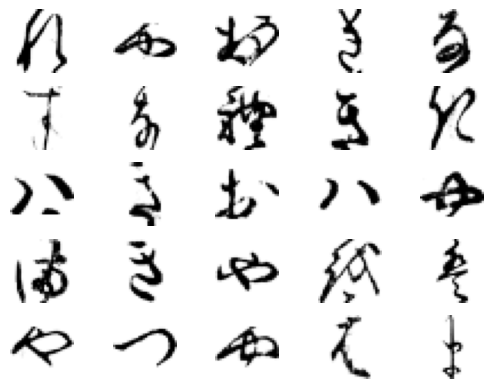

In [368]:
# Download and parse the dataset
# When working with images, the torchvision package provides useful tools to manipulate and convert image formats.
transform = transforms.Compose(
    [transforms.ToTensor()])

# Torchvision also distributes reference datasets represented in torch compatible objects
# We will save the downloaded dataset (~73MB) in a parent folder, in case we need it in another lab
trainset = torchvision.datasets.KMNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.KMNIST(root='../data', train=False, download=True, transform=transform)

# We can look at our data dimension and plot some example images
n_samples,h,w = trainset.data.shape
print("Training tensor shape:", n_samples, h, w)
print("Number of classes:",len(trainset.classes))
print("Example images:")

plt.figure()
for i in range(25):
    ax=plt.subplot(5,5,i+1)
    img = trainset.data[i]
    ax.imshow(img, cmap="Greys")
    ax.axis('off')
plt.savefig("KMNIST.png")
plt.show()

## Step 1: Data preparation

Once the dataset is downloaded, the first step is typically to cast the data into classes specifically design for model training.

Such classes are helpful to abstract batch-level operations such as shuffling, parsing, batch spliting, batch 
normalization.

In `torch`, such a class is called `DataLoader` and is implemented in [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

- Task 1: Create `DataLoader` instances built on the training and testing datasets. The dataloader should be initialized such that it shuffles the input samples, and use a batch size of `64` samples.

In [369]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64)

## Step 2: Model definition

Once the dataset is downloaded and cast in the right data structure, we must define the model which will process the data batches.

In pytorch, models are implemented by inheriting the `nn.Module` class.
When implementing a new model in pytorch, one must define the different layers and activation functions and forward pass computation. The nice thing about using a deep learning toolbox is that the forward pass and the gradient computation of the most famous layer types are readily available.

For this step we will implement the LeNet neural network architecture.

- Task 2: Implement the LeNet architecture using the class skeleton provided below. The details of the model, can be found here: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf. The main part of the class is defined for you and you are left with the implementation of the last dense layer which takes as input 84-dimensional features and outputs 10-dimensional target vectors.


Hint:
- All the required layer class are implemented in pytorch in the `nn` module.
- Functional for relu can be found in the `nn.functional` module.
- The useful classes are: 
    - nn.Linear
    - F.relu

In [370]:
""" Network definition
    The role of the Net class is to compute the forward pass of a batch of images.
    
    The __init__ function is called when the class is instanciated.
        It must contain the declaration of the different trainable and non trainable layers.
        The layers must be defined as attributes (fields) of the Net class.
        This function can take the network's hyper-parameters as arguments.
        Here we use a famous network so we can hard code the layer's sizes.
        The activation and pooling functions can be defined here or in the forward function.
    
    The forward function is called when we want a batch of images to pass through the network layers.
        It is where we describe the architecture of the network by chaining the layers together.
        It must take a batch as input, and output the network's prediction.
"""


# Task 2
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        # The images are black/white, i.e. only 1 channel is required as input to the first convolutional layer.
        # As is depicted on the image, the first layer outputs 6 channels.
        # The intermediate feature map size is 28, and we have image of size 28 in the input
        # (as opposed to 32 mentioned in the original architecture)
        # To get the correct size in the first intermediate feature map the kernel can be 5 samples wide
        # and the input image padded with 2 samples in each direction
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
                
        # At this stage, the network stops reducing the feature map sizes with pooling layers,
        # We aggregate all the remaining samples and continue with dense layers
        # How many samples are left at the input of the first dense layer ?
        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84,10)

    def forward(self, x):
        y = F.relu(self.conv1(x))
        # As mentioned in the paper, the subsampling operation keeps the maximum value in 2 x 2 patches of image.

        y = F.max_pool2d(y, 2)
        y = F.relu(self.conv2(y))
        y = F.max_pool2d(y, (2,2) )
        y = F.relu(self.conv3(y))

        # Aggregate (flatten) all the remaining extracted feature maps
        y = y.view(y.shape[0], -1)

        y = F.relu(self.fc1(y))
        y = F.log_softmax(self.fc2(y),dim=1)
    
        return y

# Instantiation, (call the __init__ function of the class)
net = Net()


In [371]:
from operator import mul
from functools import reduce

l=nn.Conv2d(1, 6, 5, padding=2, bias=True)
params=[ll for ll in l.parameters()]
print("Number of parameter tensors:",len(params))
print("Kernel tensor shape:", params[0].shape)
print("Kernel number of parameters:",reduce(mul,params[0].shape))
try:
    print("Bias tensor shape:", params[1].shape)
except:
    pass

Number of parameter tensors: 2
Kernel tensor shape: torch.Size([6, 1, 5, 5])
Kernel number of parameters: 150
Bias tensor shape: torch.Size([6])


## Step 3: Training loop

Now the data object are created and the network architecture is implemented.
Before our network can be trained, we must define the optimization criterion, the type of optimizer we will use and finally, write the training algorithm.

The optimization criterion we use is the `CrossEntropyLoss` from the `torch.nn` module.
The optimizer we use is the stochastic gradient descent `SGD`from the `torch.optim` module.

- Task 3: Your task is now to write the training loop for our neural network architecture.

Hint:
The training procedure may be decomposed into the following steps:

- Forward pass
- Loss evaluation
- Gradient computation
- Parameters update

In [372]:
# Instantiation of the loss function defined in the `opts` dictionary
criterion = opts["loss_fun"]()

# Instantiation of the optimizer with all the network's trainable parameters as arguments
optimizer = opts["optimizer_fun"](net.parameters(), **opts["optimizer_opts"])



# Task 3
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # We want the gradients of each batches to be calculated independently. 
        # We discard previously computed gradients by setting them to 0
        optimizer.zero_grad()

        ####
        # forward + evaluation + backward + optimize
        ####
        
        # During the forward pass, pytorch automatically accumulates the gradient of the output of each layer 
        # with respect to its input.
        outputs = net(inputs)
        
        # The loss can be evaluated by simply calling the criterion function with both the predicted and true labels
        loss = criterion(outputs, labels)
        
        # The final quantity required to run the update rule on the trainable parameters is the gradient of the loss
        # with respect to the parameters. The appropriate gradients must have been accumulated during the forward pass
        # and what this next step does is apply the chain rule.
        loss.backward()
        
        # Once the gradients are calculated, we can perform a step of the update rule using the optimizer object:
        optimizer.step()
        
        
        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print('Finished Training')


[1,   200] loss: 388.847
[1,   400] loss: 127.975
[1,   600] loss: 76.877
[1,   800] loss: 54.049
[2,   200] loss: 40.244
[2,   400] loss: 35.301
[2,   600] loss: 31.444
[2,   800] loss: 31.431
[3,   200] loss: 23.607
[3,   400] loss: 22.646
[3,   600] loss: 21.091
[3,   800] loss: 20.224
[4,   200] loss: 16.739
[4,   400] loss: 13.963
[4,   600] loss: 17.065
[4,   800] loss: 14.822
[5,   200] loss: 12.690
[5,   400] loss: 13.136
[5,   600] loss: 12.346
[5,   800] loss: 13.587
[6,   200] loss: 8.771
[6,   400] loss: 9.190
[6,   600] loss: 10.066
[6,   800] loss: 10.969
[7,   200] loss: 6.964
[7,   400] loss: 7.932
[7,   600] loss: 8.304
[7,   800] loss: 8.441
[8,   200] loss: 6.728
[8,   400] loss: 6.880
[8,   600] loss: 7.062
[8,   800] loss: 7.268
[9,   200] loss: 5.492
[9,   400] loss: 4.858
[9,   600] loss: 5.207
[9,   800] loss: 6.887
[10,   200] loss: 3.279
[10,   400] loss: 3.642
[10,   600] loss: 4.831
[10,   800] loss: 5.516
Finished Training


# Gradient computation in pytorch
Let us investigate the backward gradient pass a bit more.
You will find a detailed explaination of backpropagation in pytorch [here](https://amsword.medium.com/understanding-pytorchs-autograd-with-grad-fn-and-next-functions-b2c4836daa00)

<img src="./LeTweet.png" width="500">


## A simple example first

Let us go look at a simple example taken from [here](https://amsword.medium.com/understanding-pytorchs-autograd-with-grad-fn-and-next-functions-b2c4836daa00)

We define a simple differentiable operation:
- the element wise multiplication of two tensors (`z=x*y`)
- followed by the sum of the resulting elements (`l=z.sum()`).

The result tensor `l` has a `.grad_fn` attribute.
The `l.grad_fn` object has a next_functions attribute.
This will help us iterate backward on the computation graph, until we encounter the trainable weights (the leafs of the graph).

We would like to calculate the gradient of this operation wrt the two initial tensors.
- We first compute the gradients with a call to `.backward()`
- then we compute the gradients by iterating through the compute graph using the `grad_fn` attribute of the final tensor.

In [373]:
torch.manual_seed(6)
x = torch.randn(2, 1, requires_grad=True)
y = torch.randn(2, 1, requires_grad=True)
z = x * y
l = z.sum()
l.backward()
print("Gradient computed after the .backward() call:")
print(x.grad)
print(y.grad)
print()


torch.manual_seed(6)
x = torch.randn(2, 1, requires_grad=True)
y = torch.randn(2, 1, requires_grad=True)
z = x * y
l = z.sum()

dl = torch.tensor(1.)

back_sum = l.grad_fn
dz = back_sum(dl)
back_mul = back_sum.next_functions[0][0]
dx, dy = back_mul(dz)
back_x = back_mul.next_functions[0][0]
back_x(dx)

back_y = back_mul.next_functions[1][0]
back_y(dy)

print("Gradient computed after manual backprop on the compute graph:")
print(x.grad)
print(y.grad)

Gradient computed after the .backward() call:
tensor([[ 0.7185],
        [-0.6985]])
tensor([[-1.8744],
        [-0.9937]])

Gradient computed after manual backprop on the compute graph:
tensor([[ 0.7185],
        [-0.6985]], grad_fn=<CopyBackwards>)
tensor([[-1.8744],
        [-0.9937]], grad_fn=<CopyBackwards>)


We see that both approaches lead to the same gradients.

## A more systematic investigation

In [374]:
# We take the last inputs batch we encountered and run it through the network once again
outputs = net(inputs)

# We evaluate the loss 
loss = criterion(outputs, labels)

# The loss object contains a grad_fn attribute.
grad_fn = loss.grad_fn

# We write an recursive function to print the gradient computation functions we encounter.
# The functions named "AccumulateGrad" inform us that we have reached a Leaf node.
# When the leaf nodes are reached, the .grad attribute of the current tensor is ready to be populated with their gradient.
def print_back_fun(fun,i):
    if fun is None: 
        # Not sure why/when these None attributes occur
        pass
    
    elif fun.next_functions == (): 
        # When the list of next_functions is empty we reached a Leaf node, i.e. a parameter tensor
        print(i,";","Leaf",fun)
        
    else:
        # Print the current grad function and the depth of the recursion
        print(i,";", fun)
        # Iterate through the rest of the graph recursively, increase the depth of the recursion by 1
        list(map(lambda x: print_back_fun(x[0],i+1), fun.next_functions))


print_back_fun(grad_fn,0)

0 ; <NllLossBackward0 object at 0x290268d30>
1 ; <LogSoftmaxBackward0 object at 0x2a503cd30>
2 ; <LogSoftmaxBackward0 object at 0x2a503cc70>
3 ; <AddmmBackward0 object at 0x290130e50>
4 ; Leaf <AccumulateGrad object at 0x2901b8eb0>
4 ; <ReluBackward0 object at 0x2901b8370>
5 ; <AddmmBackward0 object at 0x2901b8d00>
6 ; Leaf <AccumulateGrad object at 0x2a504bc70>
6 ; <ViewBackward0 object at 0x2a504bc40>
7 ; <ReluBackward0 object at 0x2a504b430>
8 ; <NnpackSpatialConvolutionBackward0 object at 0x2a504b370>
9 ; <MaxPool2DWithIndicesBackward0 object at 0x2a504b340>
10 ; <ReluBackward0 object at 0x2a504b4c0>
11 ; <NnpackSpatialConvolutionBackward0 object at 0x2a504b730>
12 ; <MaxPool2DWithIndicesBackward0 object at 0x2a504b2e0>
13 ; <ReluBackward0 object at 0x294fc3460>
14 ; <NnpackSpatialConvolutionBackward0 object at 0x294fc31c0>
15 ; Leaf <AccumulateGrad object at 0x294fc38b0>
15 ; Leaf <AccumulateGrad object at 0x294fc34f0>
12 ; Leaf <AccumulateGrad object at 0x2a504b880>
12 ; Leaf <Ac

We encounter 10 leaf nodes, which corresponds to the number of parameter tensors in our network:

In [375]:
the_params=[p.shape for p in net.parameters()]
print("Number of parameter tensors",len(the_params),":")
the_params

Number of parameter tensors 10 :


[torch.Size([6, 1, 5, 5]),
 torch.Size([6]),
 torch.Size([16, 6, 5, 5]),
 torch.Size([16]),
 torch.Size([120, 16, 5, 5]),
 torch.Size([120]),
 torch.Size([84, 120]),
 torch.Size([84]),
 torch.Size([10, 84]),
 torch.Size([10])]

This means that, even before calling the `.backward()` function, the intermediate gradients are computed and stored during the forward pass.
The call to `.backward()` triggers the computation of the chain rule for each Leaf node (parameter tensor) of the computation graph we displayed above.


# Step 4: Testing algorithm

Now that our network has been trained, we can measure the performance on the held out test dataset.
The measure which we will use is the accuracy.

- Task 4: Write the code necessary to compute the accuracy on the held out test set.

Hint:
 - To avoid unnecessary computations, make sure that the gradient is not computed while the test samples pass through the network.
 - A probabilistic interpretation of the network's output is not required when computing the accuracy. All we need is the index of the largest output. To get the probabilistic interpretation you can use a softmax.

In [376]:
# Accuracy score
# Task 4
from datetime import datetime

total=0
correct=0
start_time = datetime.now()
print("with torch.no_grad()")
# To avoid the computation of the gradients during the forward pass,
# We use the torch.no_grad() environment
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        outputs = outputs.argmax(1)
        correct += (outputs == labels).sum()
        total += labels.shape[0]

elapsed=(datetime.now()-start_time).total_seconds()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("runtime: {:.3f} sec".format(elapsed))

with torch.no_grad()
Accuracy of the network on the 10000 test images: 94 %
runtime: 0.686 sec


## with or without torch.no_grad() ?

In [377]:
print("without torch.no_grad()")

total=0
correct=0
start_time = datetime.now()
# To avoid the computation of the gradients during the forward pass,
# We use the torch.no_grad() environment
#with torch.no_grad():
for data in testloader:
    inputs, labels = data
    outputs = net(inputs)
    outputs = outputs.argmax(1)
    correct += (outputs == labels).sum()
    total += labels.shape[0]
elapsed=(datetime.now()-start_time).total_seconds()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("runtime: {:.3f} sec".format(elapsed))


without torch.no_grad()
Accuracy of the network on the 10000 test images: 94 %
runtime: 0.670 sec


We see that when torch.no_grad() is used, the output tensors are not populated with the gradient functions `grad_fn`. This means that the gradients are not computed during the forward pass. The memory consumption of the forward pass is thus reduced. For large models you can expect a gain in runtime and memory footprint.